In [1]:
from data_PET_test import read_data
from MCSUVR import cal_correlation
import pandas as pd
from data_PET_test import cal_MCSUVR_torch
import torch
from sklearn.model_selection import train_test_split
import numpy as np

torch.random.manual_seed(0)
np.random.seed(0)

# age = pd.read_csv("data_PET/test/NIdata.csv", header=None)[0].to_numpy()
age = pd.read_csv("data_PET/test2/Sim2NI.csv")["Age"].to_numpy()
age_max = age.max()
age /= age_max

data_FBP = read_data("data_PET/test3/MSUVRFBP_V3.csv")
data_PIB = read_data("data_PET/test3/MSUVRPIB_V3.csv")
mc_fbp = cal_MCSUVR_torch(data_FBP)
mc_pib = cal_MCSUVR_torch(data_PIB)
cor = cal_correlation(mc_fbp.cpu().numpy(), mc_pib.cpu().numpy())
print("Correlation between FBP and PIB without harmonization:", cor)



FBP_train, FBP_test, PIB_train, PIB_test, AGE_train, AGE_test = train_test_split(
    data_FBP, data_PIB, age, test_size=0.05, random_state=42
)

val_num = int(len(FBP_test) // 2)
FBP_val = FBP_test[:val_num]
PIB_val = PIB_test[:val_num]
AGE_val = AGE_test[:val_num]
FBP_test = FBP_test[val_num:]
PIB_test = PIB_test[val_num:]
AGE_test = AGE_test[val_num:]

print(
    "FBP train: ", FBP_train.shape,
    "FBP val: ", FBP_val.shape,
    "FBP test: ", FBP_test.shape,
    "PIB train: ", PIB_train.shape,
    "PIB val: ", PIB_val.shape,
    "PIB test: ", PIB_test.shape,
)




Correlation between FBP and PIB without harmonization: 0.9457248966189515
FBP train:  (12036, 85) FBP val:  (317, 85) FBP test:  (317, 85) PIB train:  (12036, 85) PIB val:  (317, 85) PIB test:  (317, 85)


In [2]:
class MLP(torch.nn.Module):
    def __init__(self, width=10, out_width=85):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(85, width)
        self.fc2 = torch.nn.Linear(width, width)
        self.fc3 = torch.nn.Linear(width, width)
        self.fc4 = torch.nn.Linear(width, out_width)
       
        self.activation1 = torch.nn.Tanh()  
        self.activation2 = torch.nn.LeakyReLU()
     
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation2(x)
    
        x = self.fc2(x)
        x = self.activation2(x)
        
        x = self.fc3(x)
        x = self.activation2(x)
     
        x = self.fc4(x)
        return x
    
class MLP_AGE(MLP):
    def __init__(self, width=10, out_width=1):
        super(MLP_AGE, self).__init__(width, out_width)
        
        
def run_exp(model, data, epochs, exp_type=None):
    
    import torch.optim as optim
    FBP_train, FBP_val, FBP_test, PIB_train, PIB_val, PIB_test = data
    best_val = -float('inf')
    model = MLP(width=200)
    opt = optim.AdamW(model.parameters(), lr=0.0005)
    loss_fn = torch.nn.functional.mse_loss
    
    for i in range(epochs):
        model.train()
        opt.zero_grad()
        PIB_pred = model(FBP_train)
        loss = loss_fn(PIB_pred, PIB_train)
        loss.backward()
        opt.step()
        
    
        model.eval()
        with torch.no_grad():
            PIB_pred_test = model(FBP_test)
            PIB_pred_val = model(FBP_val)
            # loss_test = loss_fn(PIB_pred_test, PIB_test)
            # loss_val = loss_fn(PIB_pred_val, PIB_val)
            
            MC_PIB_pred_test = cal_MCSUVR_torch(PIB_pred_test)
            MC_PIB_pred_test_real = cal_MCSUVR_torch(PIB_test)
            MC_PIB_pred_val = cal_MCSUVR_torch(PIB_pred_val)
            MC_PIB_pred_val_real = cal_MCSUVR_torch(PIB_val)
            
            val_cor = cal_correlation(
                MC_PIB_pred_val.cpu().numpy(), MC_PIB_pred_val_real.cpu().numpy()
            )
            
            if val_cor > best_val:
                best_val = val_cor
                test_cor = cal_correlation(
                    MC_PIB_pred_test.cpu().numpy(), MC_PIB_pred_test_real.cpu().numpy()
                    )      
    print(f"Best Val {best_val:.4f} -> cor: {test_cor:.4f}")
            

# Paired Translation

In [3]:
FBP_val = torch.tensor(FBP_val, dtype=torch.float32)
FBP_test = torch.tensor(FBP_test, dtype=torch.float32)
PIB_val = torch.tensor(PIB_val, dtype=torch.float32)
PIB_test = torch.tensor(PIB_test, dtype=torch.float32)
AGE_val = torch.tensor(AGE_val, dtype=torch.float32)
AGE_test = torch.tensor(AGE_test, dtype=torch.float32)

In [4]:
for num in [10, 50, 100, 500, 1000, 2000, 5000, 10000]:
    print(f"Running experiment with {num} training data")
    
    train_idx = np.random.choice(len(FBP_train), size=num, replace=False)
    FBP_train_ = FBP_train[train_idx]
    PIB_train_ = PIB_train[train_idx]
    
    # tensor
    FBP_train_ = torch.tensor(FBP_train_, dtype=torch.float32)
    
    PIB_train_ = torch.tensor(PIB_train_, dtype=torch.float32)
   
    
    
    data = (
    FBP_train_, FBP_val, FBP_test,
    PIB_train_, PIB_val, PIB_test
    )
    run_exp(MLP(), data, epochs=200)
            

Running experiment with 10 training data
Best Val 0.9555 -> cor: 0.9540
Running experiment with 50 training data
Best Val 0.9875 -> cor: 0.9872
Running experiment with 100 training data
Best Val 0.9878 -> cor: 0.9874
Running experiment with 500 training data
Best Val 0.9873 -> cor: 0.9876
Running experiment with 1000 training data
Best Val 0.9880 -> cor: 0.9880
Running experiment with 2000 training data
Best Val 0.9875 -> cor: 0.9875
Running experiment with 5000 training data
Best Val 0.9873 -> cor: 0.9875
Running experiment with 10000 training data
Best Val 0.9873 -> cor: 0.9876


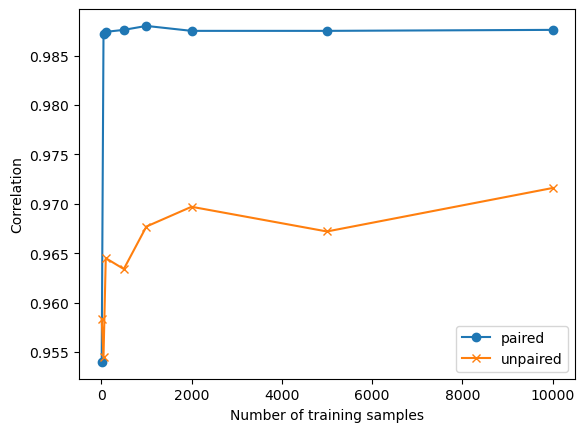

In [5]:
import matplotlib.pyplot as plt
num_samples = [10, 50, 100, 500, 1000, 2000, 5000, 10000]
test_cor_paired = [0.9540, 0.9872, 0.9874, 0.9876, 0.9880, 0.9875, 0.9875, 0.9876] 
test_cor_unpaired = [0.9583, 0.9545, 0.9645, 0.9634, 0.9677, 0.9697, 0.9672, 0.9716]

plt.figure()
plt.plot(num_samples, test_cor_paired, marker='o', label="paired")
plt.plot(num_samples, test_cor_unpaired, marker='x', label="unpaired")
plt.xlabel("Number of training samples")
plt.ylabel("Correlation")
plt.legend()

# Age prediction

In [24]:
#### DATA 
num = 1000
train_idx = np.random.choice(len(FBP_train), size=num, replace=False)
FBP_train_ = FBP_train[train_idx]
PIB_train_ = PIB_train[train_idx]
AGE_train_ = AGE_train[train_idx]

FBP_train_ = torch.tensor(FBP_train_, dtype=torch.float32)    
PIB_train_ = torch.tensor(PIB_train_, dtype=torch.float32)
AGE_train_ = torch.tensor(AGE_train_, dtype=torch.float32)



#### MODEL
import torch.optim as optim
best_test = float('inf')
model = MLP_AGE(width=300)
opt = optim.AdamW(model.parameters(), lr=0.0005)
loss_fn = torch.nn.functional.l1_loss
loss_fn_l1 = torch.nn.functional.l1_loss

best_val = float('inf')
for i in range(1000):
    model.train()
    opt.zero_grad()
    AGE_pred = model(PIB_train_)
    loss = loss_fn(AGE_pred.ravel(), AGE_train_)
    loss.backward()
    opt.step()
     
    
    model.eval()
    with torch.no_grad():
        age_pred_val = model(PIB_val)
        loss_val = loss_fn_l1(age_pred_val.ravel()*age_max, AGE_val*age_max)
        
        if loss_val < best_val:
            best_val = loss_val
            age_pred_test = model(PIB_test)
            loss_test = loss_fn_l1(age_pred_test.ravel()*age_max, AGE_test*age_max)
                
print(f"Best Val {best_val:.4f} -> loss: {loss_test:.4f}")

Best Val 4.2574 -> loss: 4.0467


# TSNE

# TSNE for paired_val_FBP and paired_test_FBP
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

paired_FBP = torch.cat([paired_val_FBP, paired_test_FBP], dim=0)

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(paired_FBP.cpu().numpy())

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:len(paired_val_FBP), 0], X_2d[:len(paired_val_FBP), 1], label='paired_val_FBP')
plt.scatter(X_2d[len(paired_val_FBP):, 0], X_2d[len(paired_val_FBP):, 1], label='paired_test_FBP')
plt.legend()